In [1]:
!pip install gym==0.23.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
from typing import Optional, Union, Tuple, List
import gym
import gym.envs.registration
import gym.spaces
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd

MAIN = __name__ == "__main__"
max_episode_steps = 1000
N_RUNS = 200

In [3]:
ObsType = int
ActType = int

class MultiArmedBandit(gym.Env):
    action_space: gym.spaces.Discrete
    observation_space: gym.spaces.Discrete
    num_arms: int
    stationary: bool
    arm_reward_means: np.ndarray
    arm_star: int

    def __init__(self, num_arms=10, stationary=True):
        super().__init__()
        self.num_arms = num_arms
        self.stationary = stationary
        self.observation_space = gym.spaces.Discrete(1)
        self.action_space = gym.spaces.Discrete(num_arms)
        self.reset()

    def step(self, arm: ActType) -> Tuple[ObsType, float, bool, dict]:
        '''
        Note: some documentation references a new style which has (termination, truncation) bools in place of the done bool.
        '''
        assert self.action_space.contains(arm)
        if not self.stationary:
            q_drift = self.np_random.normal(loc=0.0, scale=0.01, size=self.num_arms)
            self.arm_reward_means += q_drift
            self.best_arm = int(np.argmax(self.arm_reward_means))
        reward = self.np_random.normal(loc=self.arm_reward_means[arm], scale=1.0)
        obs = 0
        done = False
        info = dict(best_arm=self.best_arm)
        return (obs, reward, done, info)

    def reset(
        self, seed: Optional[int] = None, return_info=False, options=None
    ) -> Union[ObsType, Tuple[ObsType, dict]]:
        super().reset(seed=seed)
        if self.stationary:
            self.arm_reward_means = self.np_random.normal(loc=0.0, scale=1.0, size=self.num_arms)
        else:
            self.arm_reward_means = np.zeros(shape=[self.num_arms])
        self.best_arm = int(np.argmax(self.arm_reward_means))
        if return_info:
            return (0, dict())
        else:
            return 0

    def render(self, mode="human"):
        assert mode == "human", f"Mode {mode} not supported!"
        bandit_samples = []
        for arm in range(self.action_space.n):
            bandit_samples += [np.random.normal(loc=self.arm_reward_means[arm], scale=1.0, size=1000)]
        plt.violinplot(bandit_samples, showmeans=True)
        plt.xlabel("Bandit Arm")
        plt.ylabel("Reward Distribution")
        plt.show()

In [4]:
gym.envs.registration.register(
    id="ArmedBanditTestbed-v0",
    entry_point=MultiArmedBandit,
    max_episode_steps=max_episode_steps,
    nondeterministic=True,
    reward_threshold=1.0,
    kwargs={"num_arms": 10, "stationary": True},
)

env = gym.make("ArmedBanditTestbed-v0")
print("Our env inside its wrappers looks like: ", env)

Our env inside its wrappers looks like:  <TimeLimit<OrderEnforcing<MultiArmedBandit<ArmedBanditTestbed-v0>>>>


In [5]:
class Agent:
    '''Base class for agents in a multi-armed bandit environment (you do not need to add any implementation here)'''

    rng: np.random.Generator

    def __init__(self, num_arms: int, seed: int):
        self.num_arms = num_arms
        self.reset(seed)

    def get_action(self) -> ActType:
        raise NotImplementedError()

    def observe(self, action: ActType, reward: float, info: dict) -> None:
        pass

    def reset(self, seed: int) -> None:
        self.rng = np.random.default_rng(seed)

def run_episode(env: gym.Env, agent: Agent, seed: int):

    (rewards, was_best) = ([], [])

    env.reset(seed=seed)
    agent.reset(seed=seed)

    done = False
    while not done:
        arm = agent.get_action()
        (obs, reward, done, info) = env.step(arm)
        agent.observe(arm, reward, info)
        rewards.append(reward)
        was_best.append(1 if arm == info["best_arm"] else 0)

    rewards = np.array(rewards, dtype=float)
    was_best = np.array(was_best, dtype=int)
    return (rewards, was_best)

def test_agent(env: gym.Env, agent: Agent, n_runs=200, base_seed=1):
    all_rewards = []
    all_was_bests = []
    base_rng = np.random.default_rng(base_seed)
    for n in tqdm(range(n_runs)):
        seed = base_rng.integers(low=0, high=10_000, size=1).item()
        (rewards, corrects) = run_episode(env, agent, seed)
        all_rewards.append(rewards)
        all_was_bests.append(corrects)
    return (np.array(all_rewards), np.array(all_was_bests))

class RandomAgent(Agent):

    def get_action(self) -> ActType:
        return self.rng.integers(low=0, high=self.num_arms)

    def __repr__(self):
        # Useful when plotting multiple agents with `plot_rewards`
        return "RandomAgent"

In [6]:
num_arms = 10
stationary = True
env = gym.make("ArmedBanditTestbed-v0", num_arms=num_arms, stationary=stationary)
agent = RandomAgent(num_arms, 0)
all_rewards, all_corrects = test_agent(env, agent)
print(f"Expected correct freq: {1/10}, actual: {all_corrects.mean()}")
print(f"Average reward: {all_rewards.mean()}")

  0%|          | 0/200 [00:00<?, ?it/s]

Expected correct freq: 0.1, actual: 0.099565
Average reward: 0.006279268062420699


In [7]:
def moving_avg(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot_rewards(
    all_rewards: List[np.ndarray], 
    names: List[str],
    moving_avg_window: Optional[int] = 15,
):
    fig = go.Figure(layout=dict(template="simple_white", title_text="Mean reward over all runs"))
    for rewards, name in zip(all_rewards, names):
        rewards_avg = rewards.mean(axis=0)
        if moving_avg_window is not None:
            rewards_avg = moving_avg(rewards_avg, moving_avg_window)
        fig.add_trace(go.Scatter(y=rewards_avg, mode="lines", name=name))
    fig.show()

def plot_rewards_static(
    all_rewards: List[np.ndarray], 
    names: List[str],
    moving_avg_window: Optional[int] = 15,
):
    '''Static plotting'''
    df = pd.DataFrame()
    for rewards, name in zip(all_rewards, names):
        df[name] = rewards.mean(axis=0)
    df.rolling(moving_avg_window).mean().plot(figsize=(16, 8), title="Mean reward over all runs")

In [8]:
class RewardAveraging(Agent):
    def __init__(self, num_arms: int, seed: int, epsilon: float, optimism: float):
        self.epsilon = epsilon
        self.optimism = optimism
        super().__init__(num_arms, seed)

    def get_action(self):
        if self.rng.random() < self.epsilon:
            return self.rng.integers(low=0, high=self.num_arms).item()
        else:
            return np.argmax(self.Q)
        
    def observe(self, action, reward, info):
        self.N[action] += 1
        self.Q[action] += (reward - self.Q[action]) / self.N[action]

    def reset(self, seed: int):
        super().reset(seed)
        self.N = np.zeros(self.num_arms)
        self.Q = np.full(self.num_arms, self.optimism, dtype=float)

    def __repr__(self):
        # For the legend, when plotting
        return f"RewardAveraging(eps={self.epsilon}, optimism={self.optimism})"

  0%|          | 0/200 [00:00<?, ?it/s]

RewardAveraging(eps=0.1, optimism=0)
 -> Frequency of correct arm: 0.7145
 -> Average reward: 1.3688


  0%|          | 0/200 [00:00<?, ?it/s]

RewardAveraging(eps=0.1, optimism=5)
 -> Frequency of correct arm: 0.7660
 -> Average reward: 1.3923


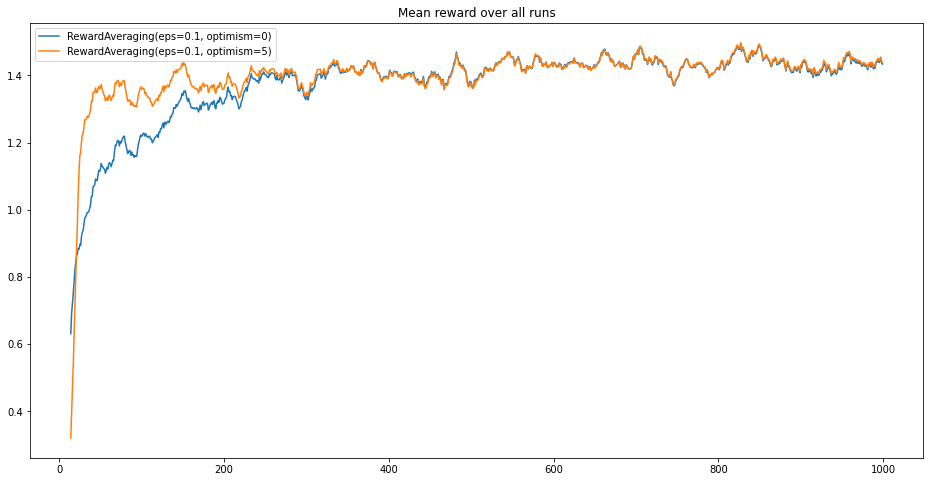

In [9]:
num_arms = 10
stationary = True
names, all_rewards = [], []
env = gym.make("ArmedBanditTestbed-v0", num_arms=num_arms, stationary=stationary)

for optimism in [0, 5]:
    agent = RewardAveraging(num_arms, 0, epsilon=0.1, optimism=optimism)
    (rewards, num_correct) = test_agent(env, agent, n_runs=N_RUNS, base_seed=1)
    names.append(str(agent))
    all_rewards.append(rewards)
    print(agent)
    print(f" -> Frequency of correct arm: {num_correct.mean():.4f}")
    print(f" -> Average reward: {rewards.mean():.4f}")

# plot_rewards(all_rewards, names, moving_avg_window=15)
plot_rewards_static(all_rewards, names, 15)

In [10]:
class CheatyMcCheater(Agent):
    def __init__(self, num_arms: int, seed: int):
        super().__init__(num_arms, seed)
        self.best_arm = 0
        pass

    def get_action(self):
        return self.best_arm

    def observe(self, action, reward, info):
        self.best_arm = info['best_arm']

    def __repr__(self):
        return "CheatyMcCheater"

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

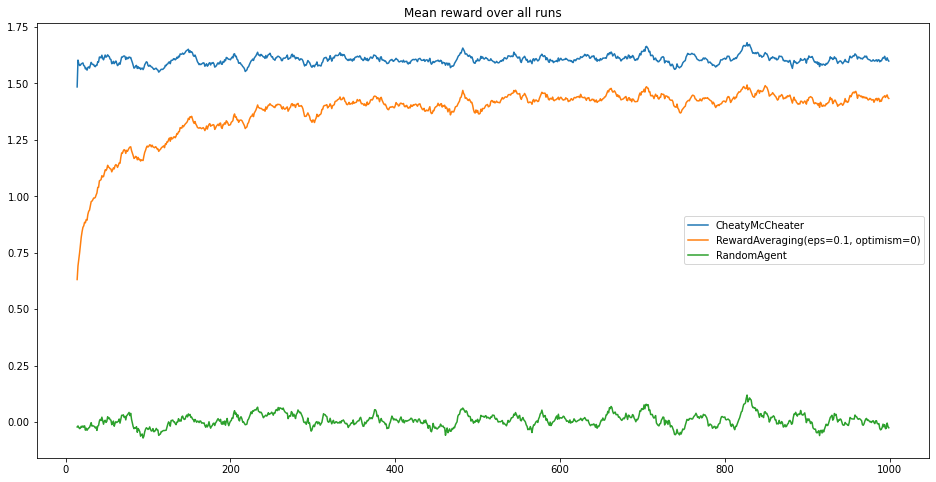

In [11]:
cheater = CheatyMcCheater(num_arms, 0)
reward_averaging = RewardAveraging(num_arms, 0, epsilon=0.1, optimism=0)
random = RandomAgent(num_arms, 0)

names = []
all_rewards = []

for agent in [cheater, reward_averaging, random]:
    (rewards, num_correct) = test_agent(env, agent, n_runs=N_RUNS, base_seed=1)
    names.append(str(agent))
    all_rewards.append(rewards)

plot_rewards_static(all_rewards, names, 15)

In [12]:
class UCBActionSelection(Agent):
    def __init__(self, num_arms: int, seed: int, c: float):
        super().__init__(num_arms, seed)
        self.c = c

    def get_action(self):
        if 0 in self.N:
            return np.argwhere(self.N == 0)[0][0]
        else:
            return np.argmax(self.Q + self.c * np.sqrt(np.log(self.t) / self.N))

    def observe(self, action, reward, info):
        self.t += 1
        self.N[action] += 1
        self.Q[action] += (reward - self.Q[action]) / self.N[action]

    def reset(self, seed: int):
        super().reset(seed)
        self.t = 1
        self.N = np.zeros(self.num_arms)
        self.Q = np.zeros(self.num_arms, dtype=float)

    def __repr__(self):
        return f"UCBActionSelection(c={self.c})"

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

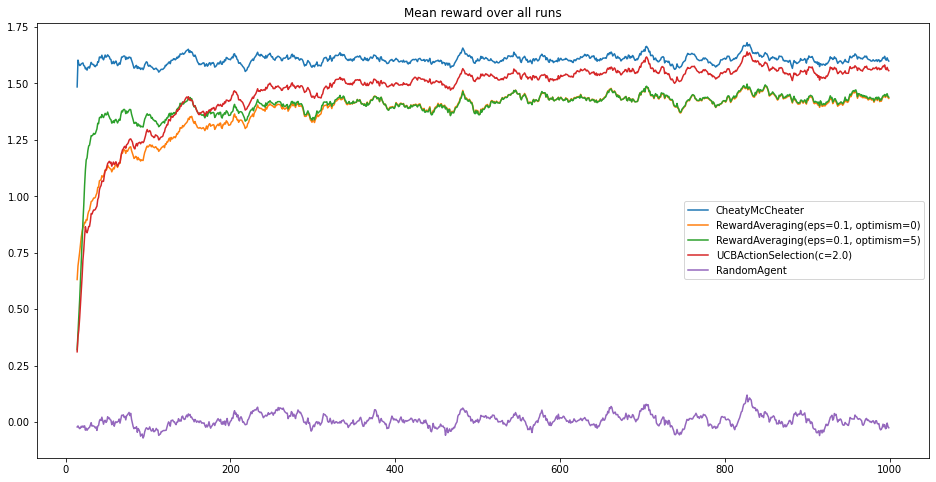

In [13]:
cheater = CheatyMcCheater(num_arms, 0)
reward_averaging = RewardAveraging(num_arms, 0, epsilon=0.1, optimism=0)
reward_averaging_optimism = RewardAveraging(num_arms, 0, epsilon=0.1, optimism=5)
ucb = UCBActionSelection(num_arms, 0, c=2.0)
random = RandomAgent(num_arms, 0)

names = []
all_rewards = []

for agent in [cheater, reward_averaging, reward_averaging_optimism, ucb, random]:
# for agent in [ucb, random]:
    (rewards, num_correct) = test_agent(env, agent, n_runs=N_RUNS, base_seed=1)
    names.append(str(agent))
    all_rewards.append(rewards)

plot_rewards_static(all_rewards, names, 15)